In [1]:
# %run "Scripts/dataprep.py"
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('Scripts')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils import *
from SSVEPDataset import SSVEPDataset
from classes import *
from SSVEPDataloader import *

from sklearn import preprocessing
import os
import time
import copy
from functools import partial

def read_data(dataframe):
    return torch.tensor(pd.read_csv(dataframe['path'], names = range(1, 16+1), dtype = float).values)

def dataVisualization(X):
    X = X.squeeze().T
    
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot()
    ax.imshow(X, cmap = 'gray')

In [2]:
dataType = '512'
data = pd.read_csv('SSVEPDataset_'+dataType+'.csv')
dataset = SSVEPDataset(data)

batchSize = 16
dataloaders, datasetsSizes = SSVEPDataloaders(dataset, batchSize)
# example = next(iter(dataloaders['train']))['series']

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# device = 'cpu'

In [3]:
class Autoencoder(nn.Module):
    def __init__(self,):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            ConvBlock(1, 16, kernel_size = (257, 1))
        )
        self.decoder = nn.Sequential(
            DeconvBlock(16, 1, kernel_size = (257, 1)),
        )
        
    def forward(self, X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X

    
class MergedModel(nn.Module):
    def __init__(self, Encoder, Classifier):
        super(MergedModel, self).__init__()
        self.Encoder = Encoder
        self.Temp = nn.Conv2d(1, 3, kernel_size = 11, padding = 11//2).double()
        self.Classifier = Classifier.double()
        
    def forward(self, X):
        X = self.Encoder(X)
        X = X.reshape((X.shape[1], 1, 256, 256))
        X = self.Temp(X)
        X = self.Classifier(X)
        return X    

Autoencoder = Autoencoder().double().to(device)

In [4]:
optimizer = optim.Adam(Autoencoder.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [ ]:
criterion = nn.MSELoss()
Autoencoder, stats, bestLoss = train(Autoencoder, dataloaders, criterion, optimizer, scheduler, device,
                         num_epochs = 10)

In [7]:
Autoencoder(exemplo.to(device))

tensor([[[[0.0000, 0.0000, 0.0096,  ..., 0.0129, 0.0099, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0334, 0.0441, 0.0278,  ..., 0.0292, 0.0332, 0.0000],
          ...,
          [0.0217, 0.0320, 0.0133,  ..., 0.0180, 0.0148, 0.4011],
          [0.0143, 0.0174, 0.0024,  ..., 0.0054, 0.0026, 0.0000],
          [0.0151, 0.0185, 0.0119,  ..., 0.0152, 0.0147, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1362, 0.1367,  ..., 0.1258, 0.1252, 0.1246],
          ...,
          [0.1266, 0.1296, 0.1297,  ..., 0.1299, 0.1299, 0.1307],
          [0.0487, 0.0493, 0.0491,  ..., 0.0496, 0.0498, 0.0499],
          [0.0045, 0.0045, 0.0043,  ..., 0.0046, 0.0048, 0.0045]]],


        [[[0.0142, 0.0050, 0.0066,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

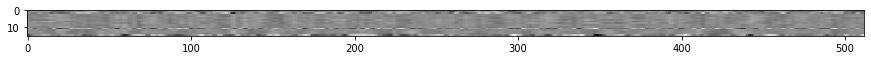

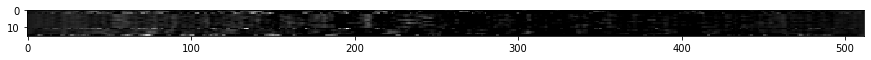

In [6]:
exemplo = iter(dataloaders['train']).next()['series']
stage = iter(dataloaders['train']).next()['class']
dataVisualization(exemplo[0])
dataVisualization(Autoencoder(exemplo.to(device))[0].cpu().detach().numpy())

In [5]:
Encoder = Autoencoder.encoder
Classifier = models.resnet18(pretrained = True)
Classifier.fc = nn.Linear(512, 5)

model = MergedModel(Encoder, Classifier).to(device)

In [ ]:
criterion = nn.MSELoss()
model, stats, bestLoss = train(model, dataloaders, criterion, optimizer, scheduler, device,
                         num_epochs = 10, temp = 1)

***

In [9]:
ConvArithSelect('R5', i = 256, k = 5, s = 1)

252

In [26]:
ConvArithSelect('R5', i = 512, k = 77, s = 1)

436

In [7]:
# ** Training algorithms

def train(model, dataloaders, criterion, optimizer, scheduler, device,
          num_epochs = 25, learningRate = 1e-3, temp = 0):
    since = time.time()
    bestModel = copy.deepcopy(model.state_dict())
    bestLoss = np.inf
    
    trainLoss = []
    validLoss = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            runningLoss = 0.0
            runningCorrects = 0
            
            for sample in dataloaders[phase]:
                inputs = sample['series'].to(device)
                labels = sample['class'].to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if temp == 0:
                        loss = criterion(outputs, inputs)
                    else:
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels.double())
                    
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                runningLoss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()
                
            epochLoss = runningLoss/datasetsSizes[phase]
            
            if phase == 'train':
                trainLoss.append(epochLoss)
            else:
                validLoss.append(epochLoss)
            
            print('{} Loss: {:.4f}'.format(phase, epochLoss))
            
            if phase == 'val' and epochLoss < bestLoss:
                bestLoss = epochLoss
                bestModel = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(bestLoss))
    
    model.load_state_dict(bestModel)
    return model, [trainLoss, validLoss], bestLoss

In [8]:
n = 13

In [9]:
n = n + 1
modelPath = path('Models\\Autoencoders\\ImageGeneration')
modelName = 'Autoencoder'+str(n)
file = open(modelPath/modelName+".txt", 'w')

model, stats, bestLoss = train(model, dataloaders, criterion, optimizer, scheduler, device,
                         num_epochs = 10)

file.write(str(model)+"\n\n")
file.write("Best Val Loss:{}\n\n".format(bestLoss))
file.write("Training Loss: {}\n\n".format(stats[0]))
file.write("Validation Loss: {}\n\n".format(stats[1]))
file.close()

Directory Models\Autoencoders\ImageGeneration loaded successfully.
Epoch 0/9
----------
train Loss: 0.0801
val Loss: 0.0365

Epoch 1/9
----------
train Loss: 0.0367
val Loss: 0.0363

Epoch 2/9
----------
train Loss: 0.0346
val Loss: 0.0319

Epoch 3/9
----------
train Loss: 0.0288
val Loss: 0.0267

Epoch 4/9
----------
train Loss: 0.0271
val Loss: 0.0259

Epoch 5/9
----------
train Loss: 0.0266
val Loss: 0.0255

Epoch 6/9
----------
train Loss: 0.0241
val Loss: 0.0238

Epoch 7/9
----------
train Loss: 0.0232
val Loss: 0.0237

Epoch 8/9
----------
train Loss: 0.0233
val Loss: 0.0234

Epoch 9/9
----------
train Loss: 0.0230
val Loss: 0.0235

Training complete in 14m 32s
Best val Loss: 0.023418
